Neuromorphic engineering I

## Lab 8: Silicon Synaptic Circuits

Team member : Pietro Bonazzi, Wencan Huang

Date: 25.11.2021

----------------------------------------------------------------------------------------------------------------------

This week, we will see how synaptic circuits generate currents when stimulated by voltage pulses. Specifically we will measure the response of the synapse to a single pulse, and to a sequence of spikes.

The objectives of this lab are to:
- Analyze log-domain synapse circuits.
- Measure the response properties of the diff-pair integrator (DPI) synapse and of the dual diff-pair integrator (DDI) synapse.


## 1. Prelab

**A Differential Pair Integrator circuit**

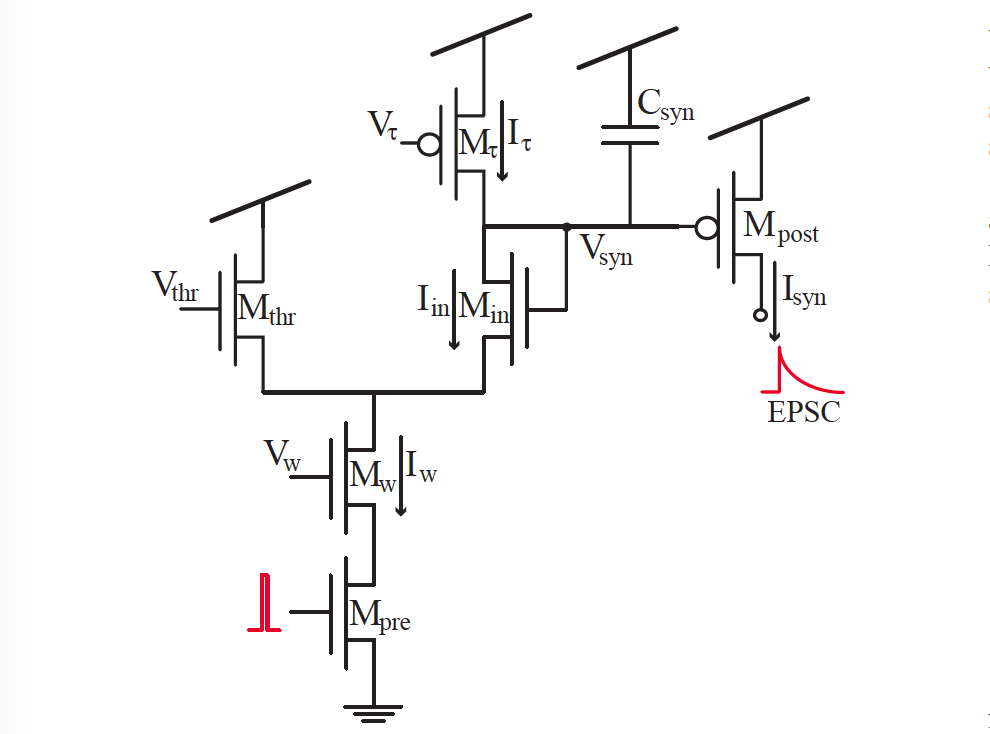

**(1)** Write the equations characterizing $I_{w}, I_{thr} , I_{in}, I_{\tau}, I_{syn}, I_C$ assuming all corresponding FETs are in saturation and operate in weak-inversion.

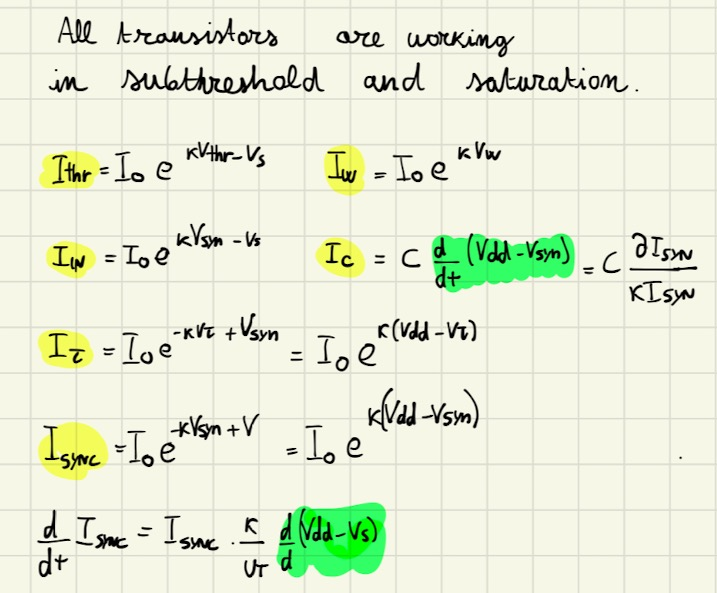

**(2)** What is the time constant of the circuit?

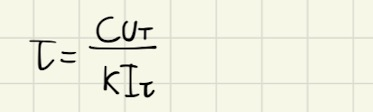

**(3)** Derive the circuit's response to a step input assuming $I_{w}(t < 0) = 0, I_{w}(t > 0) \gg I_{\tau}$.

**(4)** Derive the circuit's response to a step input assuming $I_{w}(t < 0) \gg I_{\tau}, I_{w}(t > 0) = 0$.


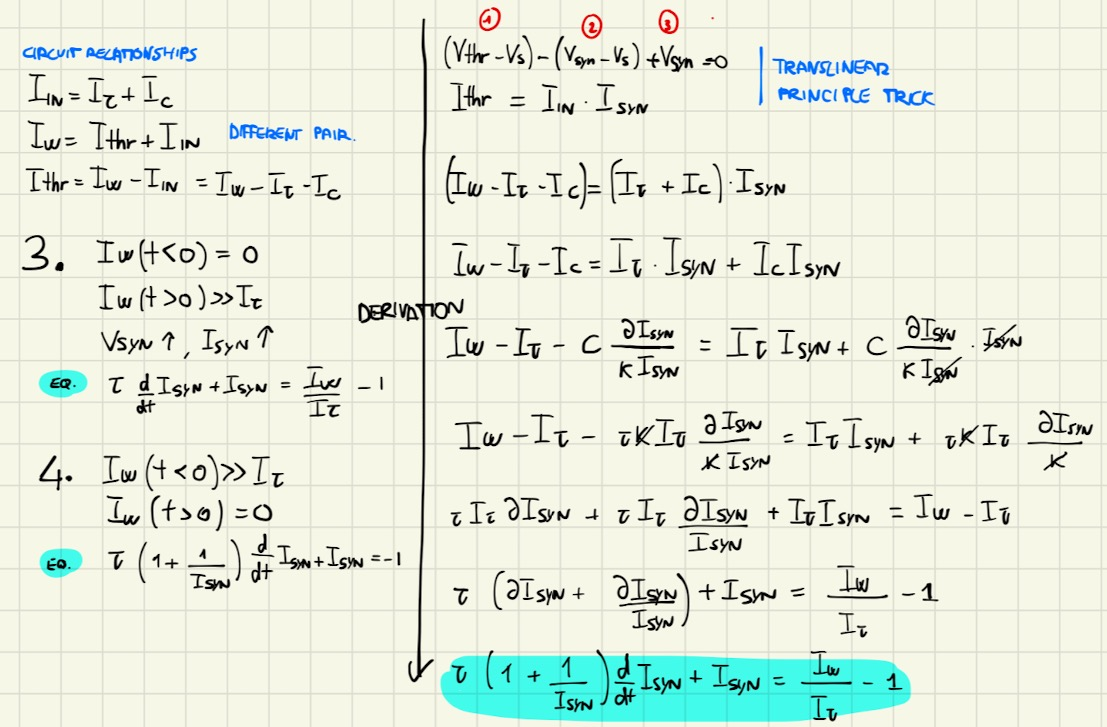

**(5)** Suppose we stimulate the circuit with a regular spike train of frequency $f$ (high enough). What happens to $I_{syn}$ in steady-state (average value)? 

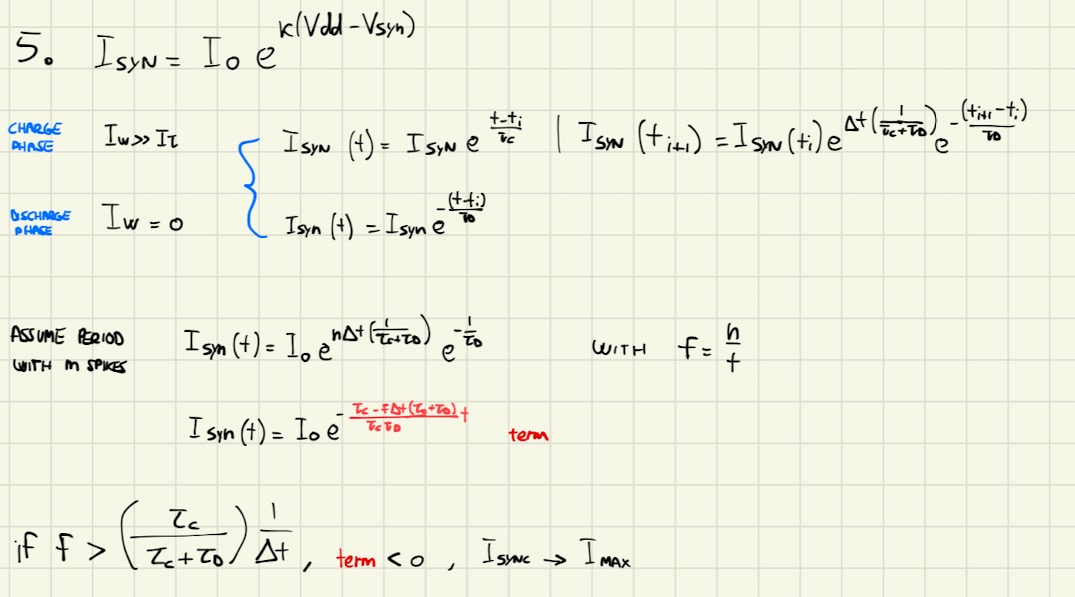

**(6)** In what conditions (tau and thr) is the step response dependent only on $I_{w}$?


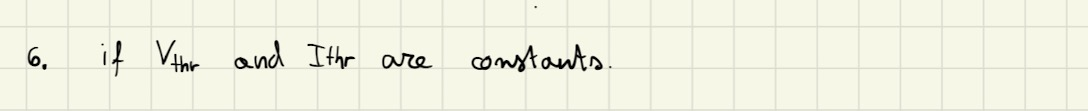

**(7)** (optional) Below shows the pulse extender circuit. If an infinitely short pulse (active high) is presented at the input `PEX_PIN_ACI`, what does the output `PEX_POUT_ACO` look like and how does `PEX_VTAU_N` determine it's characteristic?

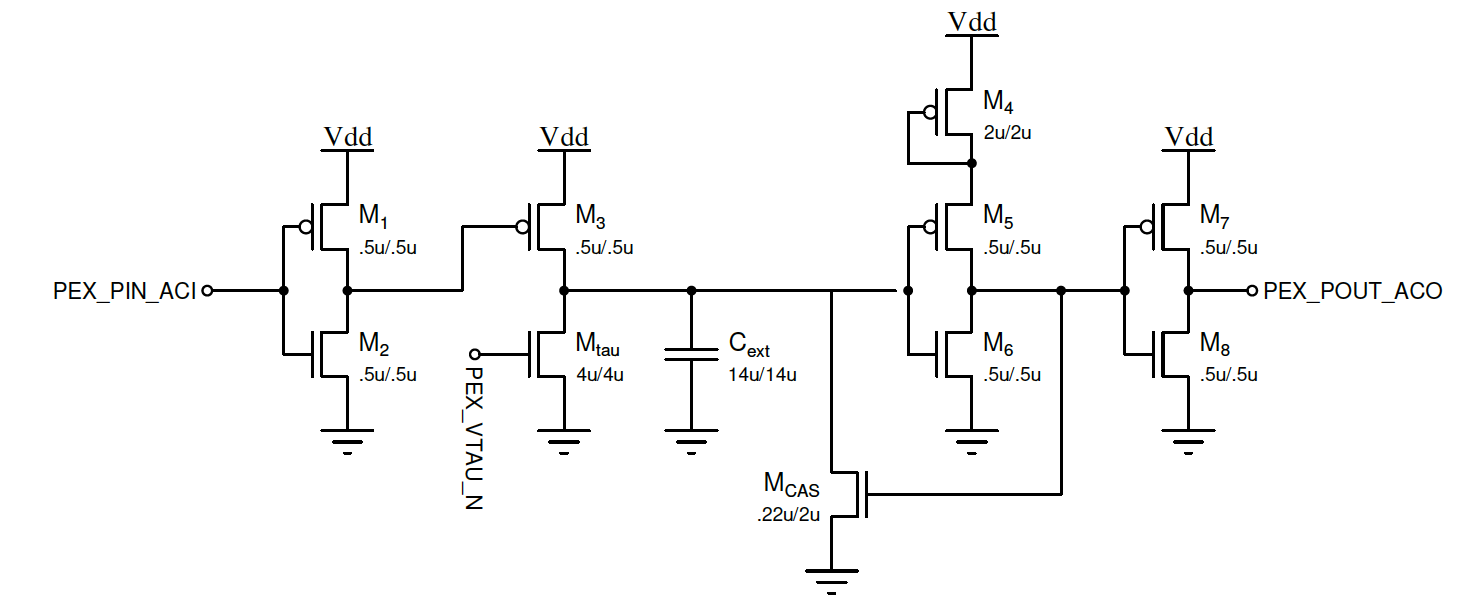

# 2 Setup

## 2.1 Connect the device

In [ ]:
# import the necessary libraries
import pyplane
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [ ]:
# create a Plane object and open the communication
if 'p' not in locals():
    p = pyplane.Plane()
    try:
        p.open('/dev/ttyACMx')
    except RuntimeError as e:
        del p
        print(e)

In [ ]:
# Send a reset signal to the board, check if the LED blinks
p.reset()

In [ ]:
# Try to read something, make sure the chip responses
p.read_current(pyplane.ReadCurrentChannel.GO0)

In [ ]:
 # If any of the above steps fail, delete the object, close and halt, stop the server and ask the TA to restart
# please also say your board number: ttyACMx

# del p

## 2.2 Chip configuration

* To measure DPI synapse:

p.send_coach_event(pyplane.Coach.generate_aerc_event(
    pyplane.pyplane.Coach.CurrentOutputSelect.SelectLine5,
    pyplane.Coach.VoltageOutputSelect.SelectLine2,
    pyplane.Coach.VoltageInputSelect.NoneSelected,
    pyplane.Coach.SynapseSelect.DPI,0))

## 2.3 C2F

* To set up the C2F circuit:

In [ ]:
# setup C2F
p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_HYS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 100))

p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_BIAS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255))

p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_PWLK_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255))

p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_REF_L, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255))

p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_REF_H, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255))

# setup output rail-to-rail buffer
p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.RR_BIAS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255))

## 2.4 BiasGen

In a simplified form, the output of a branch of the BiasGen will be the gate voltage $V_b$ for the bias current $I_b$, and if the current mirror has a ratio of $w$ and the bias transistor operates in subthreshold-saturation:
\begin{equation}
I_b = w\frac{BG_{fine}}{256}I_{BG_{master}}
\end{equation}
Where $I_{BG_{master}}$ is the `BiasGenMasterCurrent` $\in \left\{ 60~\rm{pA}, 460~\rm{pA}, 3.8~\rm{nA}, 30~\rm{nA}, 240~\rm{nA} \right\}$, $BG_{fine}$ is the integer fine value $\in [0, 256)$

To set a bias, use the function similar to the following:

```
p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.BIAS_NAME, \
    pyplane.Coach.BiasType.BIAS_TYPE, \
    pyplane.Coach.BiasGenMasterCurrent.MASTER_CURRENT, FINE_VALUE))
```

**You may have noticed that there are some biases that are not used to directly generate a current, but rather what matters is the voltage, e.g. $V_{gain}$, $V_{ex}$ and $V_{inh}$ in our HWTA circuit. Even though they may have a `BIAS_NAME` ending with `_N` or `_P` it only indicates that they are connected to the gate of an N- or a P-FET, but the `BIAS_TYPE` parameter can be both `_N` or `_P`. For example, setting a `_N` bias to `BIAS_TYPE = P` will only make this voltage very close to GND, which _is_ sometimes the designed use case.**

## 2.5 Pulse extender circuit

In case you didn't look into the last problem in prelab, the pulse extender circuit basically defines the pulse width, which is inversely proportional to the parameter `PEX_VTAU_N`.

# 3 DPI synapse

The **DPI synapse** receives a voltage pulse train, $V_{pulse}$, as input and
outputs a corresponding synaptic current, $I_{syn}$. Additionally, the synaptic voltage, $V_{syn}$, is provided.
Bias parameters $V_{weight}$ & $V_{tau}$ affect the amplitude and decay of the response, while $V_{thr}$ acts as an additional weight bias. $C_{syn}$ sizing was chosen for a capacitance of 2pF. 

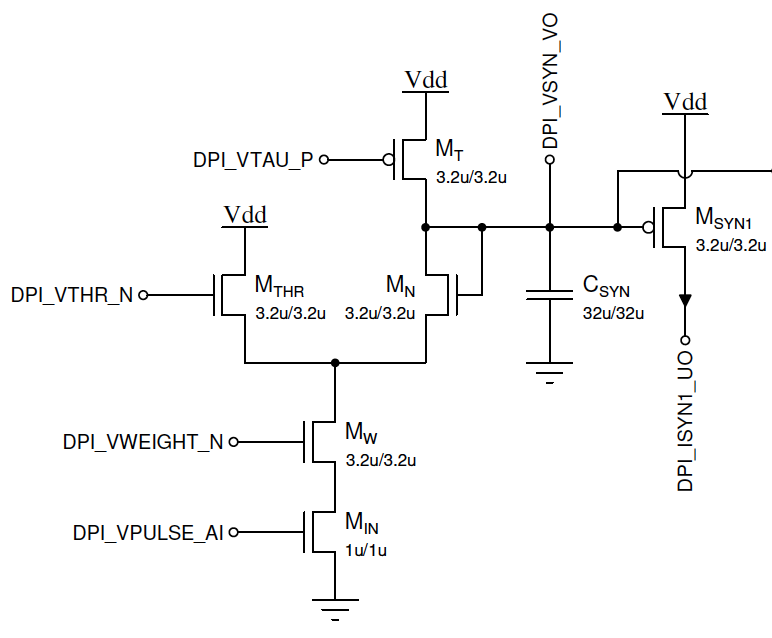

**Pin map**

**$V_{syn}$ = adc[14]**

**$I_{syn}$ = c2f[9]**

The task of this exercise it to tune the parameters and observe the behavior of the DPI synapse.

## 3.1 Basic impulse response

- **Set parameters**

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.DPI_VTAU_P, ... , ... , ...))
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.DPI_VTHR_N, ... , ... , ...))
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, ... , ... , ...))
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.PEX_VTAU_N, ... , ... , ...))

- **Data acquisition**

In [ ]:
N_trials = 10 # average over 10 trials to reduce error
N_pulses = 4 # for each trial, send 4 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
p.set_sampling_mode(pyplane.SamplingMode.Slow)
p.set_sample_rate(int(2/dT)) # set the sample period to 1/2*dT to receive data
for j in range(N_trials):
    for k in range(N_pulses):
        p.send_coach_event(pyplane.Coach.generate_pulse_event())
        for i in range(N_samples_per_pulse):
            time.sleep(dT)
            vsyn[k*N_samples_per_pulse+i] += p.read_adc_instantaneous(14)
            isyn[k*N_samples_per_pulse+i] += p.read_sampled_c2f(9)
vsyn /= N_trials
isyn /= N_trials
p.set_sampling_mode(pyplane.SamplingMode.Off)

- **Plot the data**

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.title('Figure 3.1. : DPI synapse current')
plt.plot(t, isyn, marker=10, color="red")
plt.xlabel("time")
plt.ylabel("Output current")
#plt.legend(["DPI synapse current"])
plt.grid()
plt.show()

- **Save the data**

In [ ]:
data = [t, isyn]
np.savetxt('./data/08_synapses/lab8_31.csv', data, delimiter=',') # for 3.1
#np.savetxt('./data/08_synapses/lab8_321.csv', data, delimiter=',') #  larger Iw for 3.2
#np.savetxt('./data/08_synapses/lab8_322.csv', data, delimiter=',') #  smaller Iw for 3.2
#np.savetxt('./data/08_synapses/lab8_331.csv', data, delimiter=',') #  larger Itau for 3.3
#np.savetxt('./data/08_synapses/lab8_332.csv', data, delimiter=',') #  smaller Itau for 3.3

## 3.2 Different $I_{weight}$

Repeat 3.1 with a smaller and a larger  $I_{weight}$, compare the three curves in the same plot.

In [ ]:
t_m, isyn_m = np.loadtxt('./data/08_synapses/lab8_31.csv',delimiter=",")
t_l, isyn_l = np.loadtxt('./data/08_synapses/lab8_321.csv',delimiter=",")
t_s, isyn_s = np.loadtxt('./data/08_synapses/lab8_322.csv',delimiter=",")

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.title('Figure 3.2. : DPI synapse current, changing $I_{w}$')
plt.plot(t_l, isyn_l, label="$I_w = ... $", marker=10, color="--r")
plt.plot(t_m, isyn_m, label="$I_w = ... $", marker=10, color="--b")
plt.plot(t_s, isyn_s, label="$I_w = ... $", marker=10, color="--g")
plt.xlabel("time")
plt.ylabel("Output current")
plt.legend()
plt.grid()
plt.show()

## 3.3 Different $I_{tau}$

Repeat 3.1 with a smaller and a larger  $I_{tau}$, compare the three curves in the same plot.

In [ ]:
t_m, isyn_m = np.loadtxt('./data/08_synapses/lab8_31.csv',delimiter=",")
t_l, isyn_l = np.loadtxt('./data/08_synapses/lab8_331.csv',delimiter=",")
t_s, isyn_s = np.loadtxt('./data/08_synapses/lab8_332.csv',delimiter=",")

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.title('Figure 3.3. : DPI synapse current, changing $I_{tau}$')
plt.plot(t_l, isyn_l, label="$I_{tau} = ... $", marker=10, color="--r")
plt.plot(t_m, isyn_m, label="$I_{tau} = ... $", marker=10, color="--b")
plt.plot(t_s, isyn_s, label="$I_{tau} = ... $", marker=10, color="--g")
plt.xlabel("time")
plt.ylabel("Output current")
plt.legend()
plt.grid()
plt.show()

## 3.4 Different $I_{thr}$

Repeat 3.1 with a smaller and a larger $I_{thr}$, compare the three curves in the same plot.

In [ ]:
t_m, isyn_m = np.loadtxt('./data/08_synapses/lab8_31.csv',delimiter=",")
t_l, isyn_l = np.loadtxt('./data/08_synapses/lab8_341.csv',delimiter=",")
t_s, isyn_s = np.loadtxt('./data/08_synapses/lab8_342.csv',delimiter=",")

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.title('Figure 3.4. : DPI synapse current, changing $I_{thr}$')
plt.plot(t_l, isyn_l, label="$I_{thr} = ... $", marker=10, color="--r")
plt.plot(t_m, isyn_m, label="$I_{thr} = ... $", marker=10, color="--b")
plt.plot(t_s, isyn_s, label="$I_{thr} = ... $", marker=10, color="--g")
plt.xlabel("time")
plt.ylabel("Output current")
plt.legend()
plt.grid()
plt.show()

## 3.5 Different pulse width

Repeat 3.1 with a smaller and a larger pulse width, compare the three curves in the same plot.

In [ ]:
t_m, isyn_m = np.loadtxt('./data/08_synapses/lab8_31.csv',delimiter=",")
t_l, isyn_l = np.loadtxt('./data/08_synapses/lab8_351.csv',delimiter=",")
t_s, isyn_s = np.loadtxt('./data/08_synapses/lab8_352.csv',delimiter=",")

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.title('Figure 3.5. : DPI synapse current, changing $V_{pulse}$')
plt.plot(t_l, isyn_l, label="$V_{pulse} = ... $", marker=10, color="--r")
plt.plot(t_m, isyn_m, label="$V_{pulse} = ... $", marker=10, color="--b")
plt.plot(t_s, isyn_s, label="$V_{pulse} = ... $", marker=10, color="--g")
plt.xlabel("time")
plt.ylabel("Output current")
plt.legend()
plt.grid()
plt.show()

## 3.6 Average output in steady state (Optional)

Find a set of parameters (incl. input pulse frequency) to show the case that you derived in prelab when the time constant of the input is (much) faster than the time constant of the neuron.

# 4 Dual DPI synapse (Optional)

The **Dual DPI synapse** consists of two DPI synapses, one excitatory and the other inhibitory. Both branches receive the same voltage pulse train, $V_{pulse}$, as input and outputs a corresponding synaptic current, $I_{syn}$. Additionally, the synaptic voltages, $V_{exsyn}$ & $V_{inhsyn}$, are provided.
Bias parameters $V_{weight}$ & $V_{tau}$ affect the amplitude and decay of the response,
while $V_{thr}$ acts as an additional weight bias (the bias inputs of both branches are tied
together). $C_{exsyn}$ sizing was chosen for a capacitance of
2pF and $C_{inhsyn}$ = 0.7$C_{exsyn}$. 

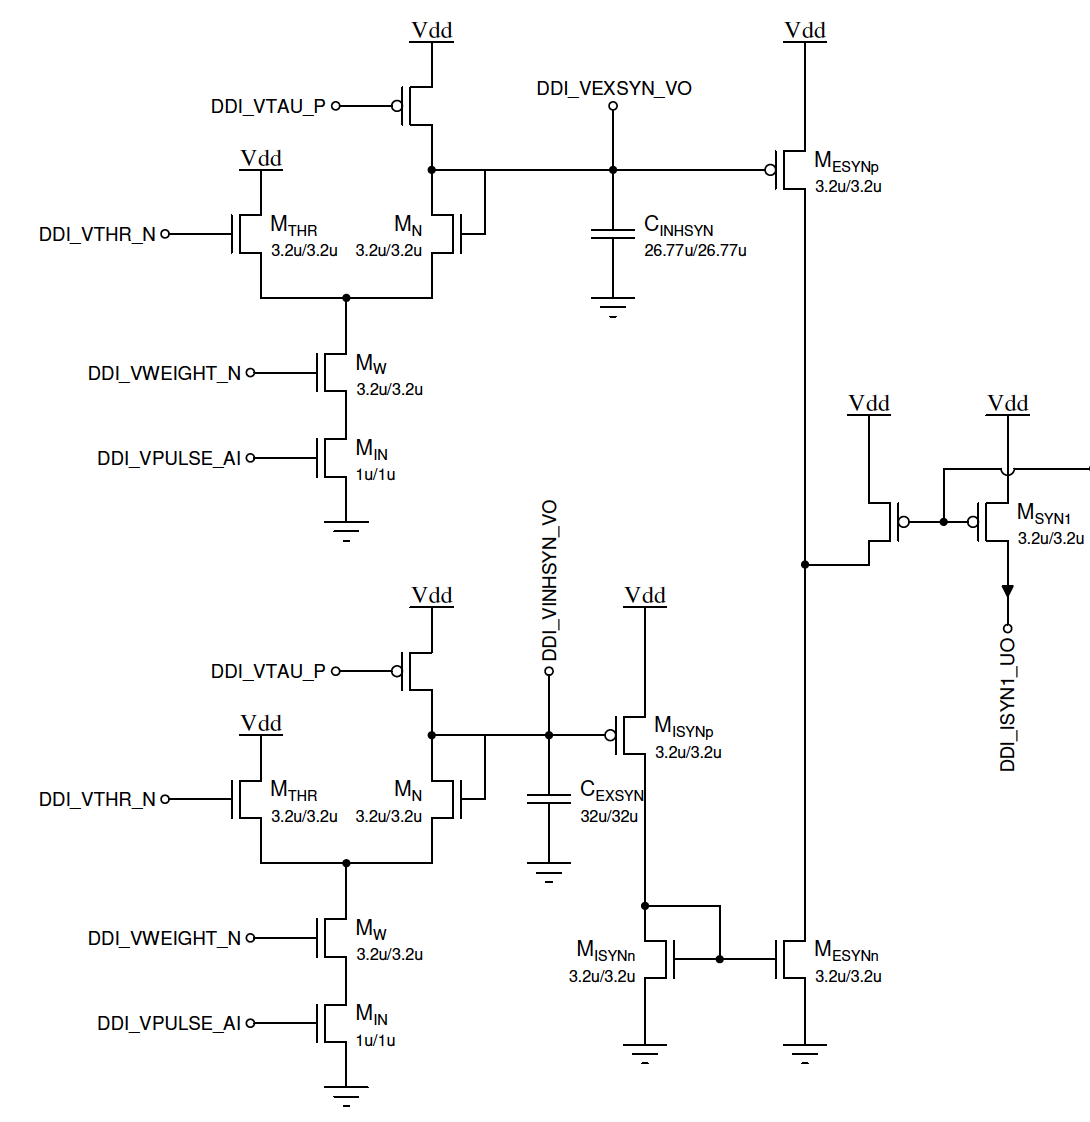

**Pin map**

**$V_{syn,exc}$ = adc[13]**

**$V_{syn,exc}$ = adc[12]**

**$I_{syn,sum}$ = c2f[10]**

* Chip configuration (notice that `DPI` becomes `DDI`!)

In [ ]:
p.send_coach_event(pyplane.Coach.generate_aerc_event(
    pyplane.pyplane.Coach.CurrentOutputSelect.SelectLine5,
    pyplane.Coach.VoltageOutputSelect.SelectLine2,
    pyplane.Coach.VoltageInputSelect.NoneSelected,
    pyplane.Coach.SynapseSelect.DDI,0))

* Set same parameters as 3.1 (notice that all `DPI` becomes `DDI`!)

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.DDI_VTAU_P, ... , ... , ...))
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.DDI_VTHR_N, ... , ... , ...))
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.DDI_VWEIGHT_N, ... , ... , ...))
p.send_coach_event(pyplane.Coach.generate_biasgen_event(pyplane.Coach.BiasAddress.PEX_VTAU_N, ... , ... , ...))

* Measure and compare the two curves in the same plot (notice the change in pin map!)

# 5 Postlab

Construct a circuit that updates its synaptic weight based on the STDP learning rule.